In [1]:
%cd "/content/drive/MyDrive/Image Classification/CLS - tensorflow 2"

/content/drive/MyDrive/Image Classification/CLS - tensorflow 2


In [3]:
import cv2
import numbers
import collections.abc as collections

import math
import torch
import torchvision
import torchvision.transforms.functional as TF
from visualizer import *
from augmenter.base_transform import *
from utils.someones import *

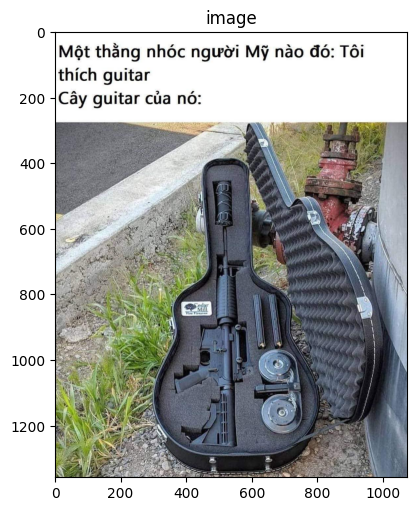

In [4]:
img_path = "/content/drive/MyDrive/Datasets/test.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

visual_image([image], ['image'])


In [5]:
INTER_MODE = {'NEAREST': cv2.INTER_NEAREST, 'BILINEAR': cv2.INTER_LINEAR, 'BICUBIC': cv2.INTER_CUBIC}
PAD_MOD = {'constant': cv2.BORDER_CONSTANT,
           'edge': cv2.BORDER_REPLICATE,
           'reflect': cv2.BORDER_DEFAULT,
           'symmetric': cv2.BORDER_REFLECT
           }

In [6]:
def detach(tensor):
    return tensor.detach().cpu().numpy()


def torch2image(tensor):
  img = detach(tensor)
  if len(img.shape) == 4:
      img = np.transpose(img, [0, 2, 3, 1])
  else:
      img = np.transpose(img, (1, 2, 0))
  return img


In [7]:
import cv2
import copy
import random
import numpy as np

from augmenter.base_transform import BaseTransform, BaseRandomTransform
from utils.auxiliary_processing import random_range, is_numpy_image


def vflip(image):
    if not is_numpy_image(image):
        raise TypeError('Image input should be CV Image. Got {}'.format(type(image)))

    return cv2.flip(image, 1)


def hflip(image):
    if not is_numpy_image(image):
        raise TypeError('Image input should be CV Image. Got {}'.format(type(image)))

    return cv2.flip(image, 0)


class Flip(BaseTransform):
    def __init__(self, mode='horizontal'):
        self.mode = mode
        self.horizontal_list = ['horizontal', 'h']
        self.vertical_list   = ['vertical', 'v']
        self.mix_list        = ['synthetic', 's']

    def image_transform(self, image):
        if self.mode.lower() in self.horizontal_list or self.mode.lower() in self.mix_list:
            rand_point = np.random.randint(0, 2) if self.mode.lower() in self.mix_list else 1
            if rand_point:
                if isinstance(image, (tuple, list)):
                    image = [vflip(img) for img in image]
                else:
                    image = vflip(image)

        if self.mode.lower() in self.vertical_list or self.mode.lower() in self.mix_list:
            rand_point = np.random.randint(0, 2) if self.mode.lower() in self.mix_list else 1
            if rand_point:
                if isinstance(image, (tuple, list)):
                    image = [hflip(img) for img in image]
                else:
                    image = hflip(image)

        return image


class RandomFlip(BaseRandomTransform):
    def __init__(self, mode='horizontal', prob=0.5):
        self.mode = mode
        self.prob = prob
        self.aug  = Flip(mode=self.mode)

    def image_transform(self, image):
        image = self.aug(image)
        return image


class RandomHorizontalFlip(BaseRandomTransform):

    def image_transform(self, image):
        return hflip(image)


class RandomVerticalFlip(BaseRandomTransform):

    def image_transform(self, image):
        return vflip(image)

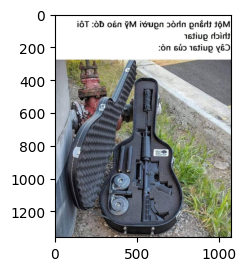

In [8]:
aug = Flip('s')

new_image = aug([image])[0]
visual_image([new_image], [''], size=(5, 5))

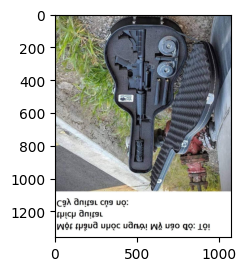

In [9]:
aug = RandomHorizontalFlip(0.5)

new_image = aug([image])[0]
visual_image([new_image], [''], size=(5, 5))

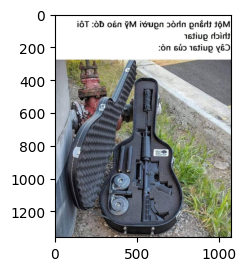

In [10]:
aug = RandomVerticalFlip(0.5)

new_image = aug([image])[0]
visual_image([new_image], [''], size=(5, 5))

In [11]:
def pad(image, padding, fill=(0, 0, 0), padding_mode='constant'):

    if not is_numpy_image(image):
        raise TypeError('Image should be CV Image. Got {}'.format(type(image)))

    if not isinstance(padding, (numbers.Number, tuple)):
        raise TypeError('Got inappropriate padding arg')
    if not isinstance(fill, (numbers.Number, str, tuple)):
        raise TypeError('Got inappropriate fill arg')
    if not isinstance(padding_mode, str):
        raise TypeError('Got inappropriate padding_mode arg')

    if isinstance(padding, collections.Sequence) and len(padding) not in [2, 4]:
        raise ValueError("Padding must be an int or a 2, or 4 element tuple, not a " +
                         "{} element tuple".format(len(padding)))

    assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric'], \
        'Padding mode should be either constant, edge, reflect or symmetric'

    if isinstance(padding, int):
        pad_left = pad_right = pad_top = pad_bottom = padding
    if isinstance(padding, collections.Sequence) and len(padding) == 2:
        pad_left = pad_right = padding[0]
        pad_top = pad_bottom = padding[1]
    if isinstance(padding, collections.Sequence) and len(padding) == 4:
        pad_left, pad_top, pad_right, pad_bottom = padding

    if isinstance(fill, numbers.Number):
        fill = (fill,) * (2 * len(image.shape) - 3)

    if padding_mode == 'constant':
        assert (len(fill) == 3 and len(image.shape) == 3) or (len(fill) == 1 and len(image.shape) == 2), \
            'channel of image is {} but length of fill is {}'.format(image.shape[-1], len(fill))

    image = cv2.copyMakeBorder(src=image,
                               top=pad_top,
                               bottom=pad_bottom,
                               left=pad_left,
                               right=pad_right,
                               borderType=PAD_MOD[padding_mode],
                               value=fill)
    return image


class Pad(BaseTransform):
    def __init__(self, padding, fill=0, padding_mode='constant'):
        assert isinstance(padding, (numbers.Number, tuple))
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']
        if isinstance(padding, collections.Sequence) and len(padding) not in [2, 4]:
            raise ValueError("Padding must be an int or a 2, or 4 element tuple, not a " +
                             "{} element tuple".format(len(padding)))

        self.padding = padding
        self.fill = fill
        self.padding_mode = padding_mode

    def image_transform(self, image):
        return pad(image, self.padding, self.fill, self.padding_mode)

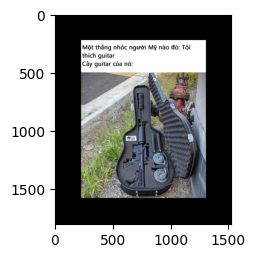

In [12]:
aug = Pad(224)

new_image = aug([image])[0]
visual_image([new_image], [''], size=(5, 5))

In [13]:
import cv2
import copy
import random
import numpy as np
import collections.abc as collections

from utils.auxiliary_processing import is_numpy_image


INTER_MODE = {
    'NEAREST': cv2.INTER_NEAREST,
    'BILINEAR': cv2.INTER_LINEAR,
    'BICUBIC': cv2.INTER_CUBIC
}

PAD_MOD = {
    'constant': cv2.BORDER_CONSTANT,
    'edge': cv2.BORDER_REPLICATE,
    'reflect': cv2.BORDER_DEFAULT,
    'symmetric': cv2.BORDER_REFLECT
}

def resize(image, size, interpolation='BILINEAR'):
    if not is_numpy_image(image):
        raise TypeError('Image input should be CV Image. Got {}'.format(type(image)))
    if not (isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)):
        raise TypeError('Got inappropriate size arg: {}'.format(size))

    if isinstance(size, int):
        h, w, c = image.shape
        if (w <= h and w == size) or (h <= w and h == size):
            return image
        if w < h:
            ow = size
            oh = int(size * h / w)
            return cv2.resize(image, dsize=(ow, oh), interpolation=INTER_MODE[interpolation])
        else:
            oh = size
            ow = int(size * w / h)
            return cv2.resize(image, dsize=(ow, oh), interpolation=INTER_MODE[interpolation])
    else:
        oh, ow = size
        return cv2.resize(image, dsize=(int(ow), int(oh)), interpolation=INTER_MODE[interpolation])


class Resize(BaseTransform):
    def __init__(self, size, interpolation='BILINEAR'):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def image_transform(self, image):
        return resize(image, self.size, self.interpolation)

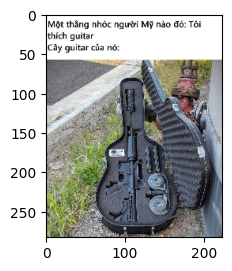

In [14]:
aug = Resize(224)

new_image = aug([image])[0]
visual_image([new_image], [''], size=(5, 5))

In [30]:
class ResizeKeepRatio(BaseTransform):
    def __init__(self,
                 size,
                 longest=0.,
                 interpolation='BILINEAR',
                 random_scale_prob=0.,
                 random_scale_range=(0.85, 1.05),
                 random_scale_area=False,
                 random_aspect_prob=0.,
                 random_aspect_range=(0.9, 1.11)):
        self.size = size if isinstance(size, (list, tuple)) else (size, size)
        self.interpolation = interpolation
        self.longest = float(longest)
        self.random_scale_prob = random_scale_prob
        self.random_scale_range = random_scale_range
        self.random_scale_area = random_scale_area
        self.random_aspect_prob = random_aspect_prob
        self.random_aspect_range = random_aspect_range

    @staticmethod
    def get_params(orin_size,
                   target_size,
                   longest,
                   random_scale_prob=0.,
                   random_scale_range=(1.0, 1.33),
                   random_scale_area=False,
                   random_aspect_prob=0.,
                   random_aspect_range=(0.9, 1.11)):
        target_h, target_w = target_size
        ratio_h = orin_size[0] / target_h
        ratio_w = orin_size[1] / target_w
        ratio = max(ratio_h, ratio_w) * longest + min(ratio_h, ratio_w) * (1. - longest)

        if random_scale_prob > 0 and random.random() < random_scale_prob:
            ratio_factor = random.uniform(random_scale_range[0], random_scale_range[1])
            if random_scale_area:
                # make ratio factor equivalent to RRC area crop where < 1.0 = area zoom,
                # otherwise like affine scale where < 1.0 = linear zoom out
                ratio_factor = 1. / math.sqrt(ratio_factor)
            ratio_factor = (ratio_factor, ratio_factor)
        else:
            ratio_factor = (1., 1.)

        if random_aspect_prob > 0 and random.random() < random_aspect_prob:
            log_aspect = (math.log(random_aspect_range[0]), math.log(random_aspect_range[1]))
            aspect_factor = math.exp(random.uniform(*log_aspect))
            aspect_factor = math.sqrt(aspect_factor)
            # currently applying random aspect adjustment equally to both dims,
            # could change to keep output sizes above their target where possible
            ratio_factor = (ratio_factor[0] / aspect_factor, ratio_factor[1] * aspect_factor)

        size = [round(x * f / ratio) for x, f in zip(orin_size, ratio_factor)]
        return size

    def image_transform(self, image):
        orin_size = image.shape[:2]
        target_size = self.get_params(orin_size, self.size, self.longest,
                                      self.random_scale_prob, self.random_scale_range, self.random_scale_area,
                                      self.random_aspect_prob, self.random_aspect_range)
        return resize(image, target_size, self.interpolation)

(283, 224, 3)


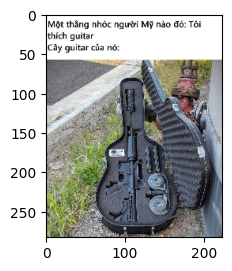

In [28]:
aug = ResizeKeepRatio(224)

new_image = aug([image])[0]
print(new_image.shape)
visual_image([new_image], [''], size=(5, 5))

In [29]:
def crop(image, top, left, height, width):
    xmin, ymin, xmax, ymax = round(top), round(left), round(top + height), round(left + width)

    try:
        check_point1 = image[xmin, ymin, ...]
        check_point2 = image[xmax - 1, ymax - 1, ...]
    except IndexError:
        image = cv2.copyMakeBorder(image,
                                   top=-min(0, xmin),
                                   bottom=max(xmax - image.shape[0], 0),
                                   left=-min(0, ymin),
                                   right=max(ymax - image.shape[1], 0),
                                   borderType=cv2.BORDER_CONSTANT,
                                   value=[0, 0, 0])
        ymax += -min(0, ymin)
        ymin += -min(0, ymin)
        xmax += -min(0, xmin)
        xmin += -min(0, xmin)

    finally:
        return image[xmin:xmax, ymin:ymax, ...].copy()


class Crop(BaseTransform):
    def __init__(self, top, left, height, width):
        self.top = top
        self.left = left
        self.height = height
        self.width = width

    def image_transform(self, image):
        return crop(image, self.top, self.left, self.height, self.width)


class RandomCrop(BaseTransform):
    def __init__(self, size, padding=0, pad_if_needed=False):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed

    @staticmethod
    def get_params(image, size):
        h, w, _ = image.shape
        th, tw = size
        if w == tw and h == th:
            return 0, 0, h, w

        try:
            i = random.randint(0, h - th)
        except ValueError:
            i = random.randint(h - th, 0)
        try:
            j = random.randint(0, w - tw)
        except ValueError:
            j = random.randint(w - tw, 0)
        return i, j, th, tw

    def image_transform(self, image):
        if self.padding > 0:
            image = pad(image, self.padding)

        # pad the width if needed
        if self.pad_if_needed and image.shape[1] < self.size[1]:
            image = pad(image, (int((1 + self.size[1] - image.shape[1]) / 2), 0))

        # pad the height if needed
        if self.pad_if_needed and image.shape[0] < self.size[0]:
            image = pad(image, (0, int((1 + self.size[0] - image.shape[0]) / 2)))

        top, left, height, width = self.get_params(image, self.size)
        return crop(image, top, left, height, width)

In [ ]:
aug = Crop(10, 20, 200, 300)

new_image = aug([image])[0]
print(new_image.shape)
visual_image([new_image], [''], size=(5, 5))

In [ ]:
x = torch.from_numpy(np.transpose(image, (2, 0, 1)).copy())

x = TF.crop(x, 10, 20, 200, 300)
y = torch2image(x)
print(y.shape)
visual_image([y], [''], size=(5, 5))


In [ ]:
aug = RandomCrop(224, pad_if_needed=True)
new_image = aug([image])[0]
print(new_image.shape)
visual_image([new_image], [''], size=(5, 5))

In [ ]:
import numbers

def center_crop(image, size):
    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    h, w = image.shape[:2]
    th, tw = size
    i = int(round((h - th) * 0.5))
    j = int(round((w - tw) * 0.5))
    return crop(image, i, j, th, tw)


class CenterCrop(BaseTransform):
    def __init__(self, size):
        self.size = size

    def image_transform(self, image):
        return center_crop(image, self.size)

In [ ]:
aug = CenterCrop(224)

new_image = aug([image])[0]
print(new_image.shape)
visual_image([new_image], [''], size=(5, 5))

In [ ]:
x = torch.from_numpy(np.transpose(image, (2, 0, 1)).copy())

x = torchvision.transforms.CenterCrop(224)(x)
y = torch2image(x)
print(y.shape)
visual_image([y], [''], size=(5, 5))


In [ ]:
def resized_crop(image, top, left, height, width, size, interpolation='BILINEAR'):
    assert is_numpy_image(image), 'image should be CV Image'
    image = crop(image, top, left, height, width)
    image = resize(image, size, interpolation)
    return image


class ResizedCrop(BaseTransform):
    def __init__(self, top, left, height, width, size, interpolation='BILINEAR'):
        self.top = top
        self.left = left
        self.height = height
        self.width = width
        self.size = size
        self.interpolation = interpolation

    def image_transform(self, image):
        return resized_crop(image, self.top, self.left, self.height, self.width, self.size, self.interpolation)


class RandomResizedCrop(BaseTransform):
    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.), interpolation='BILINEAR'):
        self.size = (size, size)
        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(image, scale, ratio):
        area = image.shape[0] * image.shape[1]
        for attempt in range(10):
            target_area = random.uniform(*scale) * area
            aspect_ratio = random.uniform(*ratio)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= image.shape[1] and h <= image.shape[0]:
                i = random.randint(0, image.shape[0] - h)
                j = random.randint(0, image.shape[1] - w)
                return i, j, h, w

        w = min(image.shape[0], image.shape[1])
        i = (image.shape[0] - w) // 2
        j = (image.shape[1] - w) // 2
        return i, j, w, w

    def image_transform(self, image):
        top, left, height, width = self.get_params(image, self.scale, self.ratio)
        return resized_crop(image, top, left, height, width, self.size, self.interpolation)


In [ ]:
aug = RandomResizedCrop(224)

new_image = aug([image])[0]
print(new_image.shape)
visual_image([new_image], [''], size=(5, 5))

In [ ]:
def five_crop(image, size):
    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."

    h, w, _ = image.shape
    crop_h, crop_w = size
    if crop_w > w or crop_h > h:
        raise ValueError("Requested crop size {} is bigger than input size {}".format(size,
                                                                                      (h, w)))
    tl = crop(image, 0, 0, crop_h, crop_w)
    tr = crop(image, 0, w - crop_w, crop_h, crop_w)
    bl = crop(image, h - crop_h, 0, crop_h, crop_w)
    br = crop(image, h - crop_h, w - crop_w, crop_h, crop_w)
    center = center_crop(image, (crop_h, crop_w))
    return (tl, tr, bl, br, center)


class FiveCrop(BaseTransform):
    def __init__(self, size):
        self.size = size
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
            self.size = size

    def image_transform(self, image):
        return five_crop(image, self.size)


In [ ]:
aug = FiveCrop(224)

new_image = aug([image])[0]

for i, ni in enumerate(new_image):
    visual_image([ni], [i], size=(5, 5))

In [ ]:
def ten_crop(img, size, vertical_flip=False):
    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."

    first_five = five_crop(img, size)

    if vertical_flip:
        img = vflip(img)
    else:
        img = hflip(img)

    second_five = five_crop(img, size)
    return first_five + second_five


class TenCrop(BaseTransform):
    def __init__(self, size, vertical_flip=False):
        self.size = size
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
            self.size = size
        self.vertical_flip = vertical_flip

    def image_transform(self, image):
        return ten_crop(image, self.size, self.vertical_flip)

In [ ]:
aug = TenCrop(224, vertical_flip=True)

new_image = aug([image])[0]

for i, ni in enumerate(new_image):
    visual_image([ni], [i], size=(5, 5))

In [ ]:
def shear_x(image, factor):
    M = np.array([[1, factor, 0], [0, 1, 0]], dtype=np.float32)
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))


class ShearX(BaseTransform):
    def __init__(self, factor):
        self.factor = factor

    def image_transform(self, image):
        return shear_x(image, self.factor)


class RandomShearX(BaseRandomTransform):
    def __init__(self, factor, prob=0.5):
        self.factor = factor
        self.prob   = prob

    @staticmethod
    def get_params(factor):
        shear_factor = 0.0

        if isinstance(factor, numbers.Number) and factor > 0:
            shear_factor = random.uniform(-factor, factor)
        elif isinstance(factor, (tuple, list)):
            shear_factor = random.uniform(factor[0], factor[1])

        return shear_factor

    def image_transform(self, image):
        shear_factor = self.get_params(self.factor)
        return shear_x(image, shear_factor)

In [ ]:
aug = RandomShearX(0.5)

new_image = aug([image])[0]
visual_image([new_image], [''])

In [ ]:
def shear_y(image, factor):
    M = np.array([[1, 0, 0], [factor, 1, 0]], dtype=np.float32)
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))


class ShearY(BaseTransform):
    def __init__(self, factor):
        self.factor = factor

    def image_transform(self, image):
        return shear_y(image, self.factor)


class RandomShearY(BaseRandomTransform):
    def __init__(self, factor, prob=0.5):
        self.factor = factor
        self.prob   = prob

    @staticmethod
    def get_params(factor):
        shear_factor = 0.0

        if isinstance(factor, numbers.Number) and factor > 0:
            shear_factor = random.uniform(-factor, factor)
        elif isinstance(factor, (tuple, list)):
            shear_factor = random.uniform(factor[0], factor[1])

        return shear_factor

    def image_transform(self, image):
        shear_factor = self.get_params(self.factor)
        return shear_y(image, shear_factor)

In [ ]:
aug = RandomShearX(0.8, 0.8)

new_image = aug([image])[0]
visual_image([new_image], [''])

In [ ]:
def translate_x(image, pct, mode='rel'):
    pixels = pct * image.shape[1] if mode == 'rel' else pct
    M = np.array([[1, 0, pixels], [0, 1, 0]], dtype=np.float32)
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))


class TranslateX(BaseTransform):
    def __init__(self, pct, mode='rel'):
        self.pct = pct
        self.mode = mode

    def image_transform(self, image):
        return translate_x(image, self.pct, self.mode)


class RandomTranslateX(BaseRandomTransform):
    def __init__(self, pct, mode='rel', prob=0.5):
        self.pct  = pct
        self.mode = mode
        self.prob = prob

    @staticmethod
    def get_params(factor):
        translate_factor = 0.0

        if isinstance(factor, numbers.Number) and factor > 0:
            translate_factor = random.uniform(-factor, factor)
        elif isinstance(factor, (tuple, list)):
            translate_factor = random.uniform(factor[0], factor[1])

        return translate_factor

    def image_transform(self, image):
        translate_factor = self.get_params(self.pct)
        return translate_x(image, translate_factor, mode=self.mode)

In [ ]:
aug = RandomTranslateX(0.5, 'rel', prob=1)

new_image = aug([image])[0]
visual_image([new_image], [''])

In [ ]:
def translate_y(image, pct, mode='rel'):
    pixels = pct * image.shape[0] if mode == 'rel' else pct
    M = np.array([[1, 0, 0], [0, 1, pixels]], dtype=np.float32)
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))


class TranslateY(BaseTransform):
    def __init__(self, pct, mode='rel'):
        self.pct = pct
        self.mode = mode

    def image_transform(self, image):
        return translate_y(image, self.pct, self.mode)


class RandomTranslateY(BaseRandomTransform):
    def __init__(self, pct, mode='rel', prob=0.5):
        self.pct  = pct
        self.mode = mode
        self.prob = prob

    @staticmethod
    def get_params(factor):
        translate_factor = 0.0

        if isinstance(factor, numbers.Number) and factor > 0:
            translate_factor = random.uniform(-factor, factor)
        elif isinstance(factor, (tuple, list)):
            translate_factor = random.uniform(factor[0], factor[1])

        return translate_factor

    def image_transform(self, image):
        translate_factor = self.get_params(self.pct)
        return translate_y(image, translate_factor, mode=self.mode)

In [ ]:
aug = RandomTranslateY(0.5, 'rel', prob=1)

new_image = aug([image])[0]
visual_image([new_image], [''])

In [ ]:
def rotate(image, angle, resample='BILINEAR', expand=False, center=None, fill=(0, 0, 0)):
    rank_size = len(image.shape)
    imgtype = image.dtype
    if not is_numpy_image(image):
        raise TypeError('Image should be PIL Image. Got {}'.format(type(image)))
    h, w, _ = image.shape
    point = center or (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(point, angle=-angle, scale=1)

    if fill:
        if isinstance(fill, int):
            if fill == -1:
                fill_color = [random.randint(0, 255) for _ in range(rank_size)]
            else:
                fill_color = [fill for _ in range(rank_size)]
        else:
            fill_color = fill
    else:
        fill_color = [0 for _ in range(rank_size)]

    if expand:
        if center is None:
            cos = np.abs(M[0, 0])
            sin = np.abs(M[0, 1])

            # compute the new bounding dimensions of the image
            nW = int((h * sin) + (w * cos))
            nH = int((h * cos) + (w * sin))

            # adjust the rotation matrix to take into account translation
            M[0, 2] += (nW / 2) - point[0]
            M[1, 2] += (nH / 2) - point[1]

            # perform the actual rotation and return the image
            dst = cv2.warpAffine(image, M, (nW, nH), borderValue=fill_color)
        else:
            xx = []
            yy = []
            for point in (np.array([0, 0, 1]), np.array([w-1, 0, 1]), np.array([w-1, h-1, 1]), np.array([0, h-1, 1])):
                target = M@point
                xx.append(target[0])
                yy.append(target[1])
            nh = int(math.ceil(max(yy)) - math.floor(min(yy)))
            nw = int(math.ceil(max(xx)) - math.floor(min(xx)))
            # adjust the rotation matrix to take into account translation
            M[0, 2] += (nw - w)/2
            M[1, 2] += (nh - h)/2
            dst = cv2.warpAffine(image, M, (nw, nh), flags=INTER_MODE[resample], borderValue=fill_color)
    else:
        dst = cv2.warpAffine(image, M, (w, h), flags=INTER_MODE[resample], borderValue=fill_color)
    return dst.astype(imgtype)


class Rotate(BaseTransform):
    def __init__(self, degrees, resample='BILINEAR', expand=False, center=None, fill=(0, 0, 0)):
        self.degrees = degrees
        self.resample = resample
        self.expand = expand
        self.center = center
        self.fill = fill

    def image_transform(self, image):
        return resized_crop(image, self.degrees, self.resample, self.expand, self.center)


class RandomRotation(BaseTransform):
    def __init__(self, degrees, resample='BILINEAR', expand=False, center=None, fill=(0, 0, 0)):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center
        self.fill = fill

    @staticmethod
    def get_params(degrees):
        return random.uniform(degrees[0], degrees[1])

    def image_transform(self, image):
        angle = self.get_params(self.degrees)
        return rotate(image, angle, self.resample, self.expand, self.center, self.fill)

In [ ]:
aug = RandomRotation(30, resample='BICUBIC', expand=True, center=(10, 1010), fill=[1, 2, 255])

new_image = aug([image])[0]
visual_image([new_image], [''])

In [ ]:
def affine(image, angle=0, translate=(0, 0), scale=1, shear=0, resample='BILINEAR', fillcolor=(0, 0, 0)):
    imgtype = image.dtype
    if not is_numpy_image(image):
        raise TypeError('img should be CV Image. Got {}'.format(type(image)))

    assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
        "Argument translate should be a list or tuple of length 2"

    assert scale > 0.0, "Argument scale should be positive"
    gray_scale = False

    if len(image.shape) == 2:
        gray_scale = True
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    rows, cols, _ = image.shape
    center = (cols * 0.5, rows * 0.5)
    angle = math.radians(angle)
    shear = math.radians(shear)
    M00 = math.cos(angle)*scale
    M01 = -math.sin(angle+shear)*scale
    M10 = math.sin(angle)*scale
    M11 = math.cos(angle+shear)*scale
    M02 = center[0] - center[0]*M00 - center[1]*M01 + translate[0]
    M12 = center[1] - center[0]*M10 - center[1]*M11 + translate[1]
    affine_matrix = np.array([[M00, M01, M02], [M10, M11, M12]], dtype=np.float32)
    dst_img = cv2.warpAffine(image,
                             affine_matrix,
                             (cols, rows),
                             flags=INTER_MODE[resample],
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=fillcolor)
    if gray_scale:
        dst_img = cv2.cvtColor(dst_img, cv2.COLOR_RGB2GRAY)
    return dst_img.astype(imgtype)


class Affine(BaseTransform):
    def __init__(self, degrees, translate=(0, 0), scale=1, shear=0, resample='BILINEAR', fillcolor=(0, 0, 0)):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.shear = shear
        self.resample = resample
        self.fillcolor = fillcolor

    def image_transform(self, image):
        return affine(image, self.degrees, self.translate, self.scale, self.shear, self.resample, self.fillcolor)


class RandomAffine(BaseTransform):
    def __init__(self, degrees=0, translate=None, scale=None, shear=None, resample='BILINEAR', fillcolor=0):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            assert isinstance(degrees, (tuple, list)) and len(degrees) == 2, \
                "degrees should be a list or tuple and it must be of length 2."
            self.degrees = degrees

        if translate is not None:
            assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
                "translate should be a list or tuple and it must be of length 2."
            for t in translate:
                if not (0.0 <= t <= 1.0):
                    raise ValueError("translation values should be between 0 and 1")
        self.translate = translate

        if scale is not None:
            assert isinstance(scale, (tuple, list)) and len(scale) == 2, \
                "scale should be a list or tuple and it must be of length 2."
            for s in scale:
                if s <= 0:
                    raise ValueError("scale values should be positive")
        self.scale = scale

        if shear is not None:
            if isinstance(shear, numbers.Number):
                if shear < 0:
                    raise ValueError("If shear is a single number, it must be positive.")
                self.shear = (-shear, shear)
            else:
                assert isinstance(shear, (tuple, list)) and len(shear) == 2, \
                    "shear should be a list or tuple and it must be of length 2."
                self.shear = shear
        else:
            self.shear = shear

        self.resample = resample
        self.fillcolor = fillcolor

    @staticmethod
    def get_params(degrees, translate, scale_ranges, shears, img_size):
        angle = random.uniform(degrees[0], degrees[1])
        if translate is not None:
            max_dx = translate[0] * img_size[1]
            max_dy = translate[1] * img_size[0]
            translations = (np.round(random.uniform(-max_dx, max_dx)),
                            np.round(random.uniform(-max_dy, max_dy)))
        else:
            translations = (0, 0)

        if scale_ranges is not None:
            scale = random.uniform(scale_ranges[0], scale_ranges[1])
        else:
            scale = 1.0

        if shears is not None:
            shear = random.uniform(shears[0], shears[1])
        else:
            shear = 0.0

        return angle, translations, scale, shear

    def image_transform(self, image):
        angle, translations, scale, shear = self.get_params(self.degrees, self.translate, self.scale, self.shear, image.shape)
        return affine(image, angle, translations, scale, shear, resample=self.resample, fillcolor=self.fillcolor)

In [ ]:
aug = Affine(30, translate=(0.1, 0.4), scale=0.7, shear=3)

new_image = aug([image])[0]
print(new_image.shape)
visual_image([new_image], [''])

In [ ]:
x = torch.from_numpy(np.transpose(image, (2, 0, 1)).copy())

x = TF.affine(x, 30, (0.1, 0.4), 0.7, 3)
y = torch2image(x)
print(y.shape)
visual_image([y], [''])


In [ ]:
aug = RandomAffine(30, translate=(0.1, 0.4), scale=(0.3, 1.7), shear=3)

new_image = aug([image])[0]
visual_image([new_image], [''])

In [ ]:
def affine6(image, anglez=0, translate=(0, 0), scale=(1, 1), shear=0, resample='BILINEAR', fillcolor=(0, 0, 0)):
    assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
        "Argument translate should be a list or tuple of length 2"

    assert isinstance(scale, (tuple, list)) and len(scale) == 2, \
        "Argument translate should be a list or tuple of length 2"

    imgtype = image.dtype
    gray_scale = False

    if len(image.shape) == 2:
        gray_scale = True
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    rows, cols, _ = image.shape
    centery = rows * 0.5
    centerx = cols * 0.5

    alpha = math.radians(shear)
    beta = math.radians(anglez)

    lambda1 = scale[0]
    lambda2 = scale[1]

    tx = translate[0]
    ty = translate[1]

    sina = math.sin(alpha)
    cosa = math.cos(alpha)
    sinb = math.sin(beta)
    cosb = math.cos(beta)

    M00 = cosb * (lambda1 * cosa ** 2 + lambda2 * sina ** 2) - sinb * (lambda2 - lambda1) * sina * cosa
    M01 = - sinb * (lambda1 * sina ** 2 + lambda2 * cosa ** 2) + cosb * (lambda2 - lambda1) * sina * cosa

    M10 = sinb * (lambda1 * cosa ** 2 + lambda2 * sina ** 2) + cosb * (lambda2 - lambda1) * sina * cosa
    M11 = + cosb * (lambda1 * sina ** 2 + lambda2 * cosa ** 2) + sinb * (lambda2 - lambda1) * sina * cosa
    M02 = centerx - M00 * centerx - M01 * centery + tx
    M12 = centery - M10 * centerx - M11 * centery + ty
    affine_matrix = np.array([[M00, M01, M02], [M10, M11, M12]], dtype=np.float32)

    dst_img = cv2.warpAffine(image,
                             affine_matrix,
                             (cols, rows),
                             flags=INTER_MODE[resample],
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=fillcolor)
    if gray_scale:
        dst_img = cv2.cvtColor(dst_img, cv2.COLOR_RGB2GRAY)
    return dst_img.astype(imgtype)


class Affine6(BaseTransform):
    def __init__(self, anglez, translate=(0, 0), scale=1, shear=0, resample='BILINEAR', fillcolor=(0, 0, 0)):
        self.anglez = anglez
        self.translate = translate
        self.scale = scale
        self.shear = shear
        self.resample = resample
        self.fillcolor = fillcolor

    def image_transform(self, image):
        return affine6(image, self.anglez, self.translate, self.scale, self.shear, self.resample, self.fillcolor)


class RandomAffine6(BaseTransform):
    def __init__(self, anglez=0, translate=(0, 0), scale=(1, 1), shear=0, resample='BILINEAR', fillcolor=(0, 0, 0)):
        if isinstance(anglez, numbers.Number):
            if anglez < 0:
                raise ValueError("If anglez is a single number, it must be positive.")
            self.anglez = (-anglez, anglez)
        else:
            assert isinstance(anglez, (tuple, list)) and len(anglez) == 2, \
                "anglez should be a list or tuple and it must be of length 2."
            self.anglez = anglez

        if translate is not None:
            assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
                "translate should be a list or tuple and it must be of length 2."
            for t in translate:
                if not (0.0 <= t <= 1.0):
                    raise ValueError("translation values should be between 0 and 1")
        self.translate = translate

        if scale is not None:
            assert isinstance(scale, (tuple, list)) and len(scale) == 2, \
                "scale should be a list or tuple and it must be of length 2."
            for s in scale:
                if s <= 0:
                    raise ValueError("scale values should be positive")
        self.scale = scale

        if isinstance(shear, numbers.Number):
            if shear < 0:
                raise ValueError("If shear is a single number, it must be positive.")
            self.shear = (-shear, shear)
        else:
            assert isinstance(shear, (tuple, list)) and len(shear) == 2, \
                "shear should be a list or tuple and it must be of length 2."
            self.shear = shear

        self.resample = resample
        self.fillcolor = fillcolor

    @staticmethod
    def get_params(img_size, anglez_range=(0, 0), translate=(0, 0), scale_ranges=(1, 1), shear_range=(0, 0)):
        angle = random.uniform(anglez_range[0], anglez_range[1])
        shear = random.uniform(shear_range[0], shear_range[1])

        max_dx = translate[0] * img_size[1]
        max_dy = translate[1] * img_size[0]
        translations = (np.round(random.uniform(-max_dx, max_dx)),
                        np.round(random.uniform(-max_dy, max_dy)))

        scale = (random.uniform(1 / scale_ranges[0], scale_ranges[0]),
                 random.uniform(1 / scale_ranges[1], scale_ranges[1]))
        return angle, translations, scale, shear

    def image_transform(self, image):
        ret = self.get_params(self.anglez, self.translate, self.scale, self.shear, image.shape)
        return affine6(image, *ret, resample=self.resample, fillcolor=self.fillcolor)

In [ ]:
aug = Affine6(30, translate=(0.1, 0.4), scale=(0.7, 1.3), shear=3)

new_image = aug([image])[0]
print(new_image.shape)
visual_image([new_image], [''])

In [ ]:
aug = RandomAffine6(30, translate=(0.1, 0.4), scale=(0.7, 1.3), shear=3)

new_image = aug([image])[0]
print(new_image.shape)
visual_image([new_image], [''])

In [ ]:
def perspective(img, fov=45, anglex=0, angley=0, anglez=0,
                translate=(0, 0), scale=(1, 1), shear=0,
                resample='BILINEAR', fillcolor=(0, 0, 0)):
    imgtype = img.dtype
    gray_scale = False

    if len(img.shape) == 2:
        gray_scale = True
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    h, w, _ = img.shape
    centery = h * 0.5
    centerx = w * 0.5

    alpha = math.radians(shear)
    beta = math.radians(anglez)

    lambda1 = scale[0]
    lambda2 = scale[1]

    tx = translate[0]
    ty = translate[1]

    sina = math.sin(alpha)
    cosa = math.cos(alpha)
    sinb = math.sin(beta)
    cosb = math.cos(beta)

    M00 = cosb * (lambda1 * cosa ** 2 + lambda2 * sina ** 2) - sinb * (lambda2 - lambda1) * sina * cosa
    M01 = - sinb * (lambda1 * sina ** 2 + lambda2 * cosa ** 2) + cosb * (lambda2 - lambda1) * sina * cosa

    M10 = sinb * (lambda1 * cosa ** 2 + lambda2 * sina ** 2) + cosb * (lambda2 - lambda1) * sina * cosa
    M11 = + cosb * (lambda1 * sina ** 2 + lambda2 * cosa ** 2) + sinb * (lambda2 - lambda1) * sina * cosa
    M02 = centerx - M00 * centerx - M01 * centery + tx
    M12 = centery - M10 * centerx - M11 * centery + ty
    affine_matrix = np.array([[M00, M01, M02], [M10, M11, M12], [0, 0, 1]], dtype=np.float32)
    # -------------------------------------------------------------------------------
    z = np.sqrt(w ** 2 + h ** 2) / 2 / np.tan(math.radians(fov / 2))

    radx = math.radians(anglex)
    rady = math.radians(angley)

    sinx = math.sin(radx)
    cosx = math.cos(radx)
    siny = math.sin(rady)
    cosy = math.cos(rady)

    r = np.array([[cosy, 0, -siny, 0],
                  [-siny * sinx, cosx, -sinx * cosy, 0],
                  [cosx * siny, sinx, cosx * cosy, 0],
                  [0, 0, 0, 1]])

    pcenter = np.array([centerx, centery, 0, 0], np.float32)

    p1 = np.array([0, 0, 0, 0], np.float32) - pcenter
    p2 = np.array([w, 0, 0, 0], np.float32) - pcenter
    p3 = np.array([0, h, 0, 0], np.float32) - pcenter
    p4 = np.array([w, h, 0, 0], np.float32) - pcenter

    dst1 = r.dot(p1)
    dst2 = r.dot(p2)
    dst3 = r.dot(p3)
    dst4 = r.dot(p4)

    list_dst = [dst1, dst2, dst3, dst4]

    org = np.array([[0, 0],
                    [w, 0],
                    [0, h],
                    [w, h]], np.float32)

    dst = np.zeros((4, 2), np.float32)

    for i in range(4):
        dst[i, 0] = list_dst[i][0] * z / (z - list_dst[i][2]) + pcenter[0]
        dst[i, 1] = list_dst[i][1] * z / (z - list_dst[i][2]) + pcenter[1]

    perspective_matrix = cv2.getPerspectiveTransform(org, dst)
    total_matrix = perspective_matrix @ affine_matrix

    result_img = cv2.warpPerspective(img, total_matrix, (w, h), flags=INTER_MODE[resample],
                                     borderMode=cv2.BORDER_CONSTANT, borderValue=fillcolor)
    if gray_scale:
        result_img = cv2.cvtColor(result_img, cv2.COLOR_RGB2GRAY)
    return result_img.astype(imgtype)


class Perspective(BaseTransform):
    def __init__(self, fov=45, anglex=0, angley=0, anglez=0, translate=(0, 0), scale=(1, 1),
                 shear=0, resample='BILINEAR', fillcolor=(0, 0, 0)):
        self.fov = fov
        self.anglex = anglex
        self.angley = angley
        self.anglez = anglez

        assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
            "translate should be a list or tuple and it must be of length 2."
        assert all([0.0 <= i <= 1.0 for i in translate]), "translation values should be between 0 and 1"
        self.translate = translate

        if scale is not None:
            assert isinstance(scale, (tuple, list)) and len(scale) == 2, \
                "scale should be a list or tuple and it must be of length 2."
            assert all([s > 0 for s in scale]), "scale values should be positive"
        self.scale = scale

        self.shear = shear
        self.resample = resample
        self.fillcolor = fillcolor

    def image_transform(self, image):
        return perspective(image, self.fov, self.anglex, self.angley, self.anglez, self.translate, self.scale, self.shear, self.resample, self.fillcolor)


class RandomPerspective(BaseTransform):
    def __init__(self, fov=0, anglex=0, angley=0, anglez=0,
                 translate=(0, 0), scale=(1, 1), shear=0,
                 resample='BILINEAR', fillcolor=(0, 0, 0)):

        assert all([isinstance(anglex, (tuple, list)) or anglex >= 0,
                    isinstance(angley, (tuple, list)) or angley >= 0,
                    isinstance(anglez, (tuple, list)) or anglez >= 0,
                    isinstance(shear, (tuple, list)) or shear >= 0]), \
            'All angles must be positive or tuple or list'
        assert 80 >= fov >= 0, 'fov should be in (0, 80)'
        self.fov = fov

        self.anglex = (-anglex, anglex) if isinstance(anglex, numbers.Number) else anglex
        self.angley = (-angley, angley) if isinstance(angley, numbers.Number) else angley
        self.anglez = (-anglez, anglez) if isinstance(anglez, numbers.Number) else anglez
        self.shear = (-shear, shear) if isinstance(shear, numbers.Number) else shear

        assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
            "translate should be a list or tuple and it must be of length 2."
        assert all([0.0 <= i <= 1.0 for i in translate]), "translation values should be between 0 and 1"
        self.translate = translate

        if scale is not None:
            assert isinstance(scale, (tuple, list)) and len(scale) == 2, \
                "scale should be a list or tuple and it must be of length 2."
            assert all([s > 0 for s in scale]), "scale values should be positive"
        self.scale = scale

        self.resample = resample
        self.fillcolor = fillcolor

    @staticmethod
    def get_params(fov_range, anglex_ranges, angley_ranges, anglez_ranges,
                   translate, scale_ranges, shear_ranges, img_size):
        fov = 90 + random.uniform(-fov_range, fov_range)
        anglex = random.uniform(anglex_ranges[0], anglex_ranges[1])
        angley = random.uniform(angley_ranges[0], angley_ranges[1])
        anglez = random.uniform(anglez_ranges[0], anglez_ranges[1])
        shear = random.uniform(shear_ranges[0], shear_ranges[1])

        max_dx = translate[0] * img_size[1]
        max_dy = translate[1] * img_size[0]
        translations = (np.round(random.uniform(-max_dx, max_dx)),
                        np.round(random.uniform(-max_dy, max_dy)))

        scale = (random.uniform(1 / scale_ranges[0], scale_ranges[0]),
                 random.uniform(1 / scale_ranges[1], scale_ranges[1]))

        return fov, anglex, angley, anglez, translate, scale, shear

    def image_transform(self, image):
        ret = self.get_params(self.fov, self.anglex, self.angley, self.anglez, self.translate, self.scale, self.shear, image.shape)
        return perspective(image, *ret, resample=self.resample, fillcolor=self.fillcolor)

In [ ]:
aug = RandomPerspective(30, 25, 56, 11, translate=(0.1, 0.4), scale=(0.7, 1.3), shear=3)

new_image = aug([image])[0]
print(new_image.shape)
visual_image([new_image], [''])